In [161]:
import torch
from torch import utils,nn,optim

import torchvision as tv
from torchvision import datasets, transforms

import torchmetrics as tm

import lightning.pytorch as pl
from lightning.pytorch import callbacks, tuner

import matplotlib.pyplot as plt

In [167]:
class FashionMNISTDataLoader(pl.LightningDataModule):
    def __init__(self,root,batch_size,num_workers):
        super(FashionMNISTDataLoader,self).__init__()
        self.root = root
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        
    def prepare_data(self):
        datasets.FashionMNIST(root = self.root,train=True,download=True)
        datasets.FashionMNIST(root = self.root,train=False,download=True)

    def setup(self, stage):
        train_dataset = datasets.FashionMNIST(root = self.root,train=True,download=False,transform = transforms.ToTensor())
        
        # Define the proportions for the split
        train_proportion = 0.8  # 80% for training
        val_proportion = 0.2  # 20% for validation

        # Calculate the sizes of training and validation sets based on the proportions
        train_size = int(train_proportion * len(train_dataset))
        val_size = len(train_dataset) - train_size
        
        # Use random_split to split the dataset
        self.train_dataset, self.val_dataset = utils.data.random_split(train_dataset, [train_size, val_size])
        

    def train_dataloader(self):
        return utils.data.DataLoader(dataset=self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=self.num_workers,pin_memory=True)
    
    def val_dataloader(self):
        return utils.data.DataLoader(dataset=self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
    
    def test_dataloader(self):
        test_dataset =  datasets.MNIST(root = self.root,train=False,download=False,transform = transforms.ToTensor())
        return utils.data.DataLoader(dataset=test_dataset,batch_size=self.batch_size,shuffle=False,num_workers=self.num_workers,pin_memory=True)
   

In [168]:
class Autoencoder(pl.LightningModule):
    
    def __init__(self,input_size,hidden_size,latent_size,output_size,lr=1e-3):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(input_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,latent_size))
        self.decoder = nn.Sequential(nn.Linear(latent_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,input_size),nn.Sigmoid())
        
        self.learning_rate = lr
        
        
    def forward(self,x):
        z = self.encoder(x)
        return self.decoder(z)
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        loss, x_hat, y = self._common_step(batch,batch_idx)
        lr = self.optimizers().param_groups[0]['lr']
        
        self.log_dict({'train_loss':loss,'learning_rate':lr},prog_bar=True,on_step=False,on_epoch=True)
        if batch_idx % 100 == 0:
            x = x[:10]
            grid = tv.utils.make_grid(x.view(-1,1,28,28))
            self.logger.experiment.add_image('mnist_images',grid,self.global_step)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        loss, x_hat, y = self._common_step(batch,batch_idx)
        
        self.log_dict({'val_loss':loss},prog_bar=True,on_step=False,on_epoch=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        loss, x_hat, y = self._common_step(batch,batch_idx)
        
        self.log_dict({'test_loss':loss},prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def _common_step(self,batch,batch_index):
        x, y = batch
        x = x.flatten(start_dim=1)
        x_hat = self.forward(x)
        loss = nn.functional.binary_cross_entropy(x_hat,x)
        return loss , x_hat, x
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Define the scheduler
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # Metric to monitor for scheduling the learning rate
                'interval': 'epoch',  # Schedule the learning rate every epoch
                'frequency': 1  # Adjust the learning rate at every epoch
            }
        }

In [169]:
# Hyperparametersa
input_size = 28*28
hidden_size = 512
latent_size = 2
output_size = 10
batch = 128
num_epoch = 2
learning_rate = 1e-3

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [170]:
model = Autoencoder(input_size, hidden_size, latent_size, output_size, lr=learning_rate).to(device)

In [171]:


logger = pl.loggers.TensorBoardLogger(save_dir='./tb/mnist', name='autoencoder', version=0.1)
profiler = pl.profilers.PyTorchProfiler(
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./dashboard/',),
    schedule=torch.profiler.schedule(skip_first=10, wait=10, warmup=1, active=2)
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="./checkpoints/mnist/autoencoder/version_0.1/", monitor="val_loss", mode="min", save_top_k=1)



dm = FashionMNISTDataLoader(root='./dataset/', batch_size=batch, num_workers=8)

In [173]:

trainer = pl.Trainer(
    # logger=logger,
    accelerator='auto',
    strategy="auto",
    devices="auto",
    min_epochs=1,
    max_epochs=50,
    precision='16-mixed',
    enable_model_summary=True,
    # profiler=profiler,
    callbacks=[callbacks.EarlyStopping('val_loss'),
               callbacks.StochasticWeightAveraging(swa_lrs=1e-3),
               checkpoint_callback],
    enable_checkpointing  = True,
    
    
)

ckpt_path=checkpoint_callback.best_model_path
print('Initialize from ', ckpt_path)


tune = tuner.Tuner(trainer)
# batch_size_tuner = tune.scale_batch_size(model, mode="binsearch", datamodule=dm, init_val=128)
lr_finder = tune.lr_find(model,dm)

Using 16bit Automatic Mixed Precision (AMP)
/Users/pranavjha/anaconda3/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning:

torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initialize from  


/Users/pranavjha/anaconda3/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning:

Checkpoint directory /Users/pranavjha/Library/CloudStorage/GoogleDrive-pranajh7@gmail.com/My Drive/Projects/Swastik/swastik_web/Learning&Experiments/PytorchTutorials/encoder-decoder/checkpoints/mnist/autoencoder/version_0.1 exists and is not empty.

/Users/pranavjha/anaconda3/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning:

User provided device_type of 'cuda', but CUDA is not available. Disabling



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Trainer was signaled to stop but the required `min_epochs=1` or `min_steps=None` has not been met. Training will continue...
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.003981071705534969
Restoring states from the checkpoint path at /Users/pranavjha/Library/CloudStorage/GoogleDrive-pranajh7@gmail.com/My Drive/Projects/Swastik/swastik_web/Learning&Experiments/PytorchTutorials/encoder-decoder/.lr_find_c7611539-f2c2-425a-8569-92ffd5c1ebb5.ckpt
Restored all states from the checkpoint at /Users/pranavjha/Library/CloudStorage/GoogleDrive-pranajh7@gmail.com/My Drive/Projects/Swastik/swastik_web/Learning&Experiments/PytorchTutorials/encoder-decoder/.lr_find_c7611539-f2c2-425a-8569-92ffd5c1ebb5.ckpt


/var/folders/2c/bnxpy2zd5tg51llb27r91_dw0000gn/T/ipykernel_51958/1847068774.py:3: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



0.003981071705534969

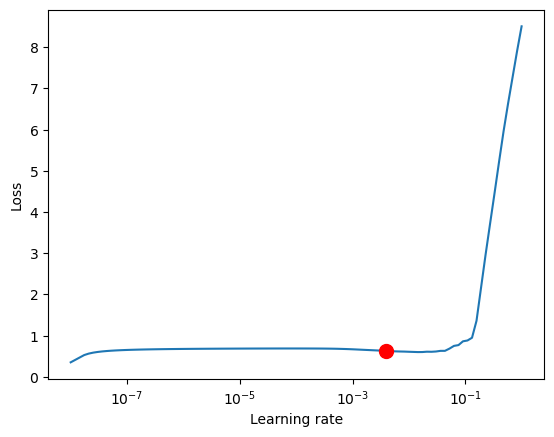

In [174]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr


In [175]:

if ckpt_path:
    trainer.fit(model, dm,ckpt_path=ckpt_path)  # Model checkpoint
else:
    trainer.fit(model, dm)
    
trainer.validate(model, dm)
trainer.test(model, dm)



  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 402 K 
1 | decoder | Sequential | 403 K 
---------------------------------------
806 K     Trainable params
0         Non-trainable params
806 K     Total params
3.227     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     0.325053334236145     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3246743381023407     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3246743381023407}]

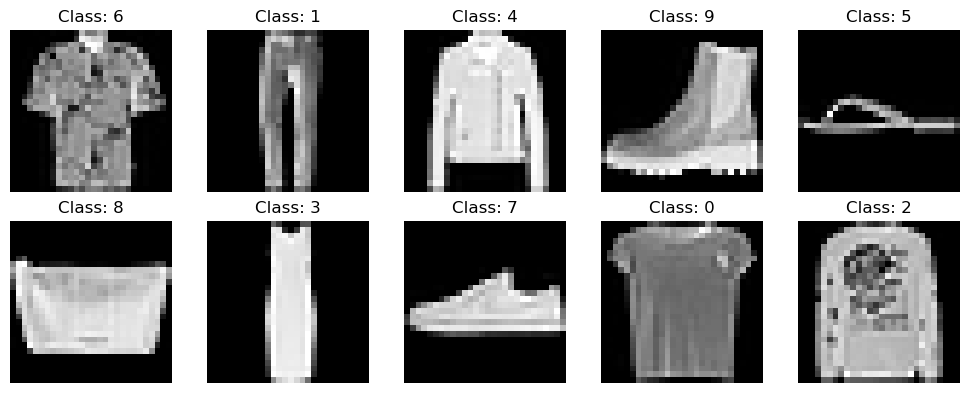

In [176]:

# Create a dictionary to store one image per class
class_images = {}

# Iterate over the dataset and store one image per class
for image, label in dm.train_dataset:
    if label not in class_images:
        class_images[label] = image
        if len(class_images) == 10:  # Stop after storing one image per class
            break

# Display the images from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, (label, image) in enumerate(class_images.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Class: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [137]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.flatten(start_dim=1))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
            
def plot_reconstructed(autoencoder, r0=(-15, 20), r1=(-5, 20), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

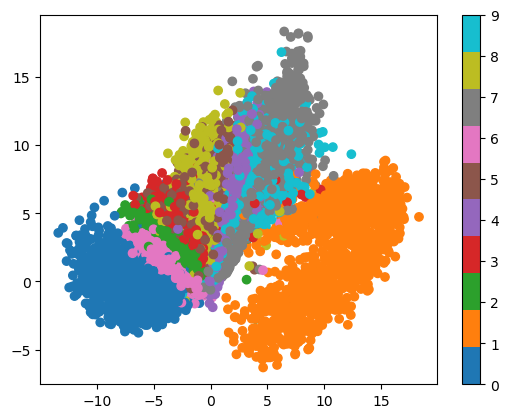

In [140]:
model.eval()
plot_latent(model,dm.train_dataloader())


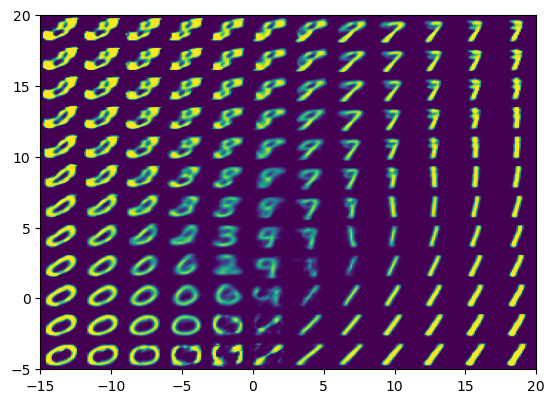

In [141]:
plot_reconstructed(model)

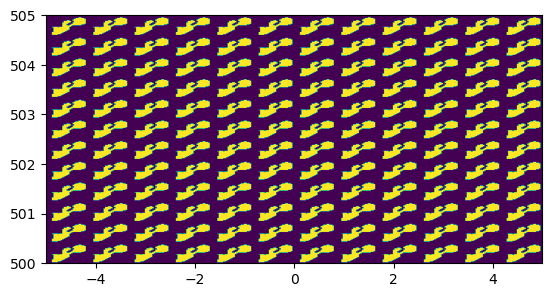

In [156]:
plot_reconstructed(model,r0=(-5,5),r1=(500,505))

In [157]:
torch.distributions.Normal(0, 1)

Normal(loc: 0.0, scale: 1.0)

In [160]:
x = torch.rand(128,1,28,28)
model.encoder(x.flatten(start_dim=1)).shape

torch.Size([128, 2])